In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
path = 'data/ml-1m/'
train = pd.read_csv(path+'old_users.csv')
test = pd.read_csv(path+'new_users.csv')

In [3]:
train.head()

,userId,movieId,rating
0,3370,40,5
1,3370,1256,4
2,3370,504,5
3,3370,376,2
4,3370,221,4


In [4]:
train.shape

(998195, 3)

In [5]:
# drop movies from test that aren't in train
test = test[test['movieId'].isin(set(train.movieId.unique()))]

In [6]:
n_users = train.userId.nunique()
n_items = train.movieId.nunique()
print('Number of users:', n_users)
print('Number of items:', n_items)

Number of users: 5940
Number of items: 3705


In [7]:
max_users = max(train.userId.max(), test.userId.max())
max_items = max(train.movieId.max(), test.movieId.max())
print("Max user ID:", max_users)
print("Max movie ID:", max_items)

Max user ID: 6039
Max movie ID: 3705


## Dot product model

In [8]:
# creating book embedding path
item_input = Input(shape=[1], name="Item-Input")
item_embedding = Embedding(max_items+1, 5, name="Item-Embedding")(item_input)
item_vec = Flatten(name="Flatten-Items")(item_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(max_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([item_vec, user_vec])
model = Model([user_input, item_input], prod)
model.compile('adam', 'mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 5)         18530       Item-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         30200       User-Input[0][0]                 
______________________________________________________________________________________________

Train on 998195 samples
Epoch 1/5
998195/998195 [==============================] - 28s 28us/sample - loss: 5.0965
Epoch 2/5
998195/998195 [==============================] - 28s 28us/sample - loss: 0.9606
Epoch 3/5
998195/998195 [==============================] - 28s 28us/sample - loss: 0.8592
Epoch 4/5
998195/998195 [==============================] - 28s 28us/sample - loss: 0.8477
Epoch 5/5
998195/998195 [==============================] - 28s 28us/sample - loss: 0.8438


Text(0, 0.5, 'Training Error')

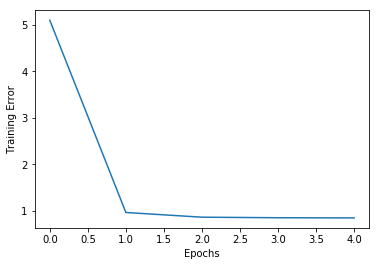

In [9]:
# model = load_model('regression_model.h5')
history = model.fit([train.userId, train.movieId], train.rating, batch_size=128, epochs=5, verbose=1)
# model.save('regression_model.h5')

plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [10]:
model.evaluate([test.userId, test.movieId], test.rating, batch_size=1028)

2013/2013 [==============================] - 0s 24us/sample - loss: 14.9381


14.938098348910335

In [11]:
predictions = model.predict([test.userId.head(10), test.movieId.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[0.05990941] 4
[0.05361777] 4
[0.05535538] 4
[0.05053423] 2
[0.06022404] 3
[0.05858846] 5
[0.0581872] 5
[0.05166112] 4
[0.05427037] 4
[0.04460068] 2


[None, None, None, None, None, None, None, None, None, None]

## Predict embeddings for new users

In [12]:
# Extract embeddings
user_em = model.get_layer('User-Embedding')

In [13]:
user_em_weights = user_em.get_weights()[0]

In [14]:
# all user weights
user_em_weights

array([[-0.8295949 ,  0.819284  , -0.7700057 , -0.7656918 ,  0.74098116],
       [-0.73876077,  0.6839065 , -0.72878826, -0.72277796,  0.7227247 ],
       [-0.7191401 ,  0.7197841 , -0.75427186, -0.72481865,  0.6943384 ],
       ...,
       [ 0.0386246 ,  0.01577068,  0.02976656, -0.03386696,  0.04523033],
       [-0.65970725,  0.77190286, -0.7280065 , -0.70004904,  0.723776  ],
       [-0.6367666 ,  0.68332404, -0.6178479 , -0.68014497,  0.74010843]],
      dtype=float32)

In [16]:
new_train, new_test, _, _ = train_test_split(test, test.rating, test_size=.2, random_state=42, stratify=test.userId)

In [17]:
model.evaluate([new_test.userId, new_test.movieId], new_test.rating, batch_size=1028)

403/403 [==============================] - 0s 69us/sample - loss: 15.0977


15.097692489624023

In [25]:
new_users = new_train.userId.unique()

for user in tqdm(new_users):
    # subset the training data for only this user
    ratings = new_train[new_train['userId']==user]
    
    # which movies has new user watched?
    watched = ratings['movieId'].values
    
    # spread the dataframe
    ratings = pd.pivot_table(ratings, values='rating', index='userId', columns='movieId').reset_index()
    del ratings.columns.name
    
    old_users = train[train['movieId'].isin(watched)]
    old_users = pd.pivot_table(old_users, values='rating', index='userId', columns='movieId').reset_index()
    del old_users.columns.name
    old_users.replace(np.nan, 0, inplace=True)
    
    # is euclidean the best distance to use here
    old_users['distance'] = pairwise_distances(old_users.iloc[:,1:].values, ratings.iloc[:,1:].values)
    
    most_similar = old_users.sort_values('distance').head(10)[['userId','distance']]

    for i in range(5):
        most_similar['em' + str(i)] = most_similar['userId'].apply(lambda x: user_em_weights[x][i])

    # now predict new user's embeddings as the weighted average of k most similar users
    new_user_em_weights = most_similar.iloc[:,2:].mean().values

    # update the embedding layer to include the predicted weights for the new user
    new_weights = user_em_weights
    new_weights[user] = new_user_em_weights

    # make the change in the model itself
    user_em.set_weights([new_weights])

In [26]:
model.evaluate([new_test.userId, new_test.movieId], new_test.rating, batch_size=1024)

403/403 [==============================] - 0s 32us/sample - loss: 1.2178


1.217821478843689

## Neural network model

In [8]:
from tensorflow.keras import backend as K

def squeeze(x):
    return K.sigmoid(x) * (5 - 1) + 1

In [9]:
# creating book embedding path
item_input = Input(shape=[1], name="Item-Input")
item_embedding = Embedding(max_items+1, 5, name="Item-Embedding")(item_input)
item_vec = Flatten(name="Flatten-Items")(item_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(max_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([item_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
d1 = Dropout(.5)(fc1)
fc2 = Dense(32, activation='relu')(d1)
d2 = Dropout(.25)(fc2)
out = Dense(1, activation=squeeze)(d2)

# Create model and compile it
model2 = Model([user_input, item_input], out)
model2.compile('adam', 'mean_squared_error')
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 5)         18530       Item-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         30200       User-Input[0][0]                 
______________________________________________________________________________________________

Train on 998195 samples
Epoch 1/10
998195/998195 [==============================] - 48s 48us/sample - loss: 0.8717
Epoch 2/10
998195/998195 [==============================] - 47s 47us/sample - loss: 0.8163
Epoch 3/10
998195/998195 [==============================] - 47s 47us/sample - loss: 0.7955
Epoch 4/10
998195/998195 [==============================] - 46s 46us/sample - loss: 0.7789
Epoch 5/10
998195/998195 [==============================] - 46s 47us/sample - loss: 0.7695
Epoch 6/10
998195/998195 [==============================] - 47s 47us/sample - loss: 0.7630
Epoch 7/10
998195/998195 [==============================] - 47s 47us/sample - loss: 0.7588
Epoch 8/10
998195/998195 [==============================] - 47s 47us/sample - loss: 0.7550
Epoch 9/10
998195/998195 [==============================] - 47s 48us/sample - loss: 0.7520
Epoch 10/10
998195/998195 [==============================] - 48s 48us/sample - loss: 0.7492


Text(0, 0.5, 'Training Error')

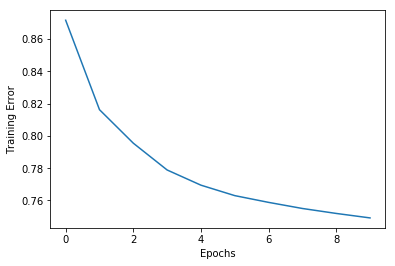

In [10]:
# model2 = load_model('regression_model2.h5')

history = model2.fit([train.userId, train.movieId], train.rating, batch_size=128, epochs=10)
# model2.save('regression_model2.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [11]:
model2.evaluate([test.userId, test.movieId], test.rating, batch_size=1024)

2013/2013 [==============================] - 0s 48us/sample - loss: 1.0702


1.0702445155284444

In [12]:
predictions = model2.predict([test.userId.head(10), test.movieId.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[3.9591734] 4
[3.7781148] 4
[3.4852905] 4
[3.5926337] 2
[3.9438477] 3
[4.1781473] 5
[3.5257006] 5
[3.860937] 4
[3.821544] 4
[2.6347399] 2


[None, None, None, None, None, None, None, None, None, None]

## Predict embeddings for new users

In [13]:
# Extract embeddings
user_em = model2.get_layer('User-Embedding')

In [14]:
user_em_weights = user_em.get_weights()[0]

In [15]:
# all user weights
user_em_weights

array([[-0.57636654,  0.37424082, -0.43145132, -0.16532883,  0.07679112],
       [ 0.07679918, -0.2527673 , -0.17654137, -0.29093048,  0.03642904],
       [ 0.21803363,  0.1800217 , -0.12867135, -0.38082793, -0.05835042],
       ...,
       [-0.00929724,  0.03369183,  0.00269888,  0.01082691, -0.0330287 ],
       [ 0.08443875,  0.15384771, -0.02711827, -0.06361145, -0.0601689 ],
       [ 0.42667565, -0.01498739,  0.03599919,  0.3957585 ,  0.56534344]],
      dtype=float32)

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
new_train, new_test, _, _ = train_test_split(test, test.rating, test_size=.2, random_state=42, stratify=test.userId)

In [18]:
model2.evaluate([new_test.userId, new_test.movieId], new_test.rating, batch_size=1028)

403/403 [==============================] - 0s 141us/sample - loss: 1.1964


1.1964356899261475

In [21]:
new_users = new_train.userId.unique()

for user in tqdm(new_users):
    # subset the training data for only this user
    ratings = new_train[new_train['userId']==user]
    
    # which movies has new user watched?
    watched = ratings['movieId'].values
    
    # spread the dataframe
    ratings = pd.pivot_table(ratings, values='rating', index='userId', columns='movieId').reset_index()
    del ratings.columns.name
    
    old_users = train[train['movieId'].isin(watched)]
    old_users = pd.pivot_table(old_users, values='rating', index='userId', columns='movieId').reset_index()
    del old_users.columns.name
    old_users.replace(np.nan, 0, inplace=True)
    
    # is euclidean the best distance to use here
    old_users['distance'] = pairwise_distances(old_users.iloc[:,1:].values, ratings.iloc[:,1:].values)
    
    most_similar = old_users.sort_values('distance').head(10)[['userId','distance']]

    for i in range(5):
        most_similar['em' + str(i)] = most_similar['userId'].apply(lambda x: user_em_weights[x][i])

    # now predict new user's embeddings as the weighted average of k most similar users
    new_user_em_weights = most_similar.iloc[:,2:].mean().values

    # update the embedding layer to include the predicted weights for the new user
    new_weights = user_em_weights
    new_weights[user] = new_user_em_weights

    # make the change in the model itself
    user_em.set_weights([new_weights])

In [22]:
model2.evaluate([new_test.userId, new_test.movieId], new_test.rating, batch_size=1028)

403/403 [==============================] - 0s 35us/sample - loss: 1.1545


1.1544885635375977

## Visualise embeddings

In [41]:
# Extract embeddings
item_em = model2.get_layer('Item-Embedding')
item_em_weights = item_em.get_weights()[0]

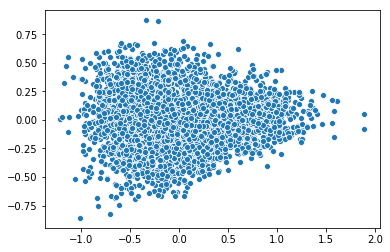

In [42]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(item_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [43]:
item_em_weights = item_em_weights / np.linalg.norm(item_em_weights, axis = 1).reshape((-1, 1))
item_em_weights[0][:10]
np.sum(np.square(item_em_weights[0]))

1.0

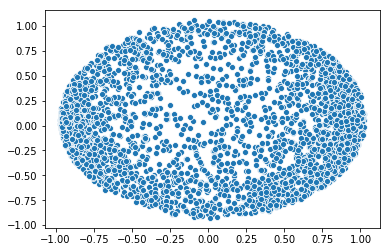

In [44]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(item_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [45]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(item_em_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3706 samples in 0.003s...
[t-SNE] Computed neighbors for 3706 samples in 0.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3706
[t-SNE] Computed conditional probabilities for sample 2000 / 3706
[t-SNE] Computed conditional probabilities for sample 3000 / 3706
[t-SNE] Computed conditional probabilities for sample 3706 / 3706
[t-SNE] Mean sigma: 0.159214
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.932922
[t-SNE] KL divergence after 300 iterations: 1.783048


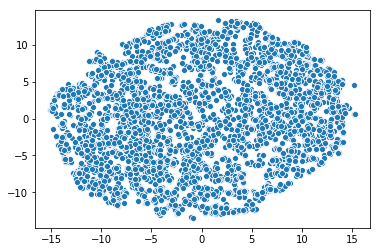

In [46]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

## Making recommendations

In [47]:
# Creating dataset for making recommendations for the first user
item_data = np.array(list(set(train.movieId)))
item_data[:5]

array([0, 1, 2, 3, 4])

In [48]:
user = np.array([1 for i in range(len(item_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [49]:
predictions = model2.predict([user, item_data])

predictions = np.array([a[0] for a in predictions])

recommended_movie_ids = (-predictions).argsort()[:5]

recommended_movie_ids

array([ 167, 2617,   44, 3629,   23], dtype=int64)

In [50]:
# print predicted scores
predictions[recommended_movie_ids]

array([4.7353106, 4.7262664, 4.70117  , 4.695665 , 4.6925473],
      dtype=float32)

In [51]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,40,Toy Story (1995),Animation|Children's|Comedy
1,573,Jumanji (1995),Adventure|Children's|Fantasy
2,1333,Grumpier Old Men (1995),Comedy|Romance
3,450,Waiting to Exhale (1995),Comedy|Drama
4,1334,Father of the Bride Part II (1995),Comedy


In [52]:
movies[movies['movieId'].isin(recommended_movie_ids)]

,movieId,title,genres
253,44,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
309,167,"Shawshank Redemption, The (1994)",Drama
513,23,Schindler's List (1993),Drama|War
2698,2617,Sanjuro (1962),Action|Adventure
3010,3629,Smashing Time (1967),Comedy
